In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from environment import HMG, DisturbedVariables
from stabilizators import StabilityRegulator
from controllers import DummyOperator

In [2]:
df = pd.read_hdf('data/test_merged.hdf')

straty_columns = df.columns[[4,5,6,7,8,9]]
zadane_columns = df.columns[[0,1,2,3]]
zaklucane_columns = df.columns[10:]

manipulated_variables = df.values[:, :4]
disturbing_variables = df.values[:, 10:-4]
disturbed_variables = df.values[:, -4:]
hmg_heat_output = df.values[:, 4]

manipulated_variables.shape, disturbing_variables.shape, disturbed_variables.shape, hmg_heat_output.shape

((950400, 4), (950400, 12), (950400, 4), (950400,))

# Proces stabilizacji

In [3]:
dummy_operator = DummyOperator()
disturbed_variables_model = DisturbedVariables()
stability_regulator = StabilityRegulator()
hmg_object = HMG()

In [4]:
[hmg_heat_output[:10].mean()]

[23.267407416999998]

In [5]:
np.append(np.delete(np.array([1,2,3,4]),0), 5)

array([2, 3, 4, 5])

In [11]:
heat_output = []

# initial regularization input
prev_man_var = manipulated_variables[59]
prev_disturbed_var = disturbed_variables[59]
prev_heat = hmg_heat_output[:60]

for t in tqdm(range(60, len(hmg_heat_output))):
    # input variables
    disturbing_var = disturbing_variables[t]
    
    # manipulated variables selection
    new_man_var = dummy_operator(prev_man_var, disturbing_var, prev_disturbed_var)

    # manipulated variables smoothing
    new_man_var = stability_regulator(prev_man_var, new_man_var)
    
    # disturbed variables estimation
    new_disturbed_var = disturbed_variables_model(new_man_var, disturbing_var, prev_disturbed_var)

    # HMG object
    new_heat = hmg_object(new_man_var, disturbing_var, new_disturbed_var, [prev_heat.mean()])
    heat_output.append(new_heat)
    
    prev_heat = np.append(np.delete(prev_heat, 0), new_heat[0])
    prev_man_var = new_man_var
    prev_disturbed_var = new_disturbed_var

 51%|█████     | 484021/950340 [48:26<46:40, 166.54it/s]  


KeyboardInterrupt: 

In [12]:
len(heat_output)

484021

In [32]:
heat_gt = hmg_heat_output[60:484081]

heat_mae = mean_absolute_error(heat_gt, heat_output)
heat_mse = mean_squared_error(heat_gt, heat_output)
heat_mae_procent = mean_absolute_percentage_error(heat_gt, heat_output)

print(f'MSE: {heat_mse}')
print(f'MAE: {heat_mae}')
print(f'MAE [%]: {heat_mae_procent}')
print(f'GT std: {np.std(heat_gt)}')
print(f'Stabilized std: {np.std(heat_output)}')
print(f'GT variance: {np.var(heat_gt)}')
print(f'Stabilized variance: {np.var(heat_output)}')
print(f'GT R: {np.max(heat_gt) - np.min(heat_gt)}') # rozstęp
print(f'Stabilized R: {np.max(heat_output) - np.min(heat_output)}') # rozstęp

MSE: 3.9259209281546754
MAE: 1.5650579929842672
MAE [%]: 0.08008878843239262
GT std: 1.9290651168223043
Stabilized std: 0.8333030244423202
GT variance: 3.72129222494065
Stabilized variance: 0.6943939305447181
GT R: 16.417771336999998
Stabilized R: 8.363550726842572


In [19]:
# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [20]:
heat_gt_ma = moving_average(heat_gt, 12000)

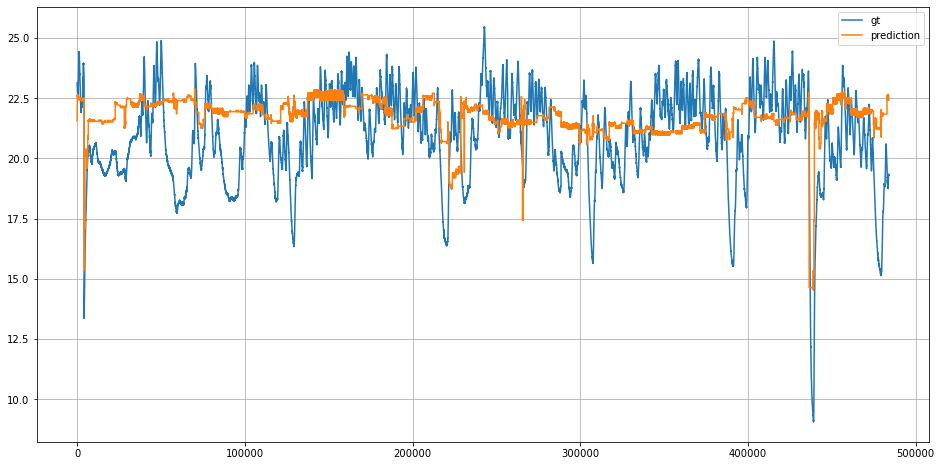

In [31]:
plt.figure(figsize=(16,8));
plt.plot(heat_gt, label='gt');
# plt.plot(heat_gt_ma, label='moving average');
plt.plot(heat_output, label='prediction');
plt.legend();
plt.grid();